## <font color=DarkTurquoise>Overall Goals</font>

<font color=Gray>The existence of the Transformers movie franchise raises a curious question: how can films that critics pan become massive box office successes, while critically acclaimed gems sometimes struggle commercially? This project explores the divide between critical and financial success in cinema, aiming to uncover what drives these differences. We’ll examine correlations between IMDb ratings and box office revenue to reveal general trends and identify outliers. Using a range of methodologies, from time-based and genre-specific analyses to sentiment analysis on plot summary, we aim to uncover patterns across genres, timeframes, and film attributes. Our approach integrates dataset merging, inflation-adjusted revenue comparisons, outlier classification, distribution analysis, and advanced sentiment modeling to answer our research questions and provide insight into this complex relationship between critics and audiences.</font>

## <font color=DarkTurquoise>Load Packages</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import json
#import holoviews as hv
#from holoviews import opts
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
import ast

from src.script.plots import *

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## <font color=DarkTurquoise>Load Datasets</font>

<font color=Gray>The `data/cleaned_data.csv` dataset contains data from two sources, described as follows:</font>

### <font color=Gray>Dataset1: CMU Dataset</font>

<font color=Gray>We load and preprocess two datasets related to `movies` and `characters`, making adjustments to ensure consistency and readability in the movie DataFrame. The main adjustments are as follows:

(1) We capitalized the first letter of each movie name, making all names follow title case with the first letter capitalized and the rest in lowercase.This step facilitates merging dataset1 and dataset2 by standardizing the movie names.

(2) We replaced any occurrences of the accented characters é and è with e.

(3) We created a column that has the year of the movie release so that we can remove duplicates that have the same name but different release year.

(4) We removed movies with empty or null values in the box office revenue column.

(5) We extracted the movie genres and languages into separate lists for storage.


Data source:http://www.cs.cmu.edu/~ark/personas/</font>

### <font color=Gray>Dataset2: IMBD Dataset</font>

<font color=Gray>We have introduced two new datasets: The `title.ratings`, which contains movie ratings and the number of voters, adding two new dimensions to our data. The `title.basics` dataset provides a mapping between IDs and movie names, helping us integrate these new dimensions into the original dataset. The main adjustments are as follows:

(1) We excluded movies with fewer than 30 reviews, as these films have too few ratings to objectively assess their quality. However, this step is open to discussion.

(2) We capitalized the first letter of all entries in the `primaryTitle` column to use as the primary key for merging with the CMU dataset, and then remove any unnecessary columns.

Data source:https://datasets.imdbws.com/</font>

In [2]:
#Load data
cleaned_data = pd.read_csv('data/cleaned_data.csv')
cleaned_data['Movie genres'] = cleaned_data['Movie genres'].apply(ast.literal_eval)
cleaned_data['Movie countries'] = cleaned_data['Movie countries'].apply(ast.literal_eval)

### <font color=Gray>Dataset3: US-CPI Dataset</font>

<font color=Gray>We first plotted the curve showing the variation in average annual box office revenue over time. Although there are some fluctuations, we can observe an overall upward trend in the curve.</font>

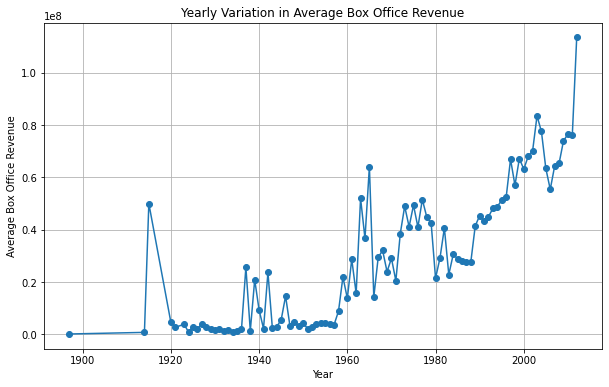

In [3]:
plot_by_year_nonadjusted(cleaned_data)


<font color=Gray>This phenomenon has several explanations. For instance, with the development of globalization, the number of cinemas has steadily increased worldwide. At the same time, advances in film production technology (such as 3D, IMAX) have enhanced the viewing experience. More theaters and improved viewing experiences attract a broader audience, driving box office revenue growth.

However, the primary factor we need to consider is that movie ticket prices have been rising each year due to `inflation`. This leads to an increase in total box office revenue, even if the number of moviegoers remains steady or slightly declines. Therefore, we need to adjust for inflation's effect on box office revenue and introduce the `US-CPI` index as a measure of inflation.</font>

In [4]:
# Load dataset
inflation = pd.read_csv('data/inflation.csv')

# Merge the inflation data with cleaned_data based on matching 'Year' and 'Movie release year' columns
cleaned_data = pd.merge(inflation, cleaned_data, left_on='Year', right_on='Movie release year', how='right').drop(columns=['CPI'])

# Calculate the adjusted revenue by multiplying 'Movie box office revenue' by the inflation 'rate'
cleaned_data['Adjusted_Revenue'] = cleaned_data['Movie box office revenue']*cleaned_data['rate']

<font color=Gray>We plotted a comparison of the average annual box office revenue before and after adjustment. It can be observed that the adjusted average annual revenue is higher than the original.</font>

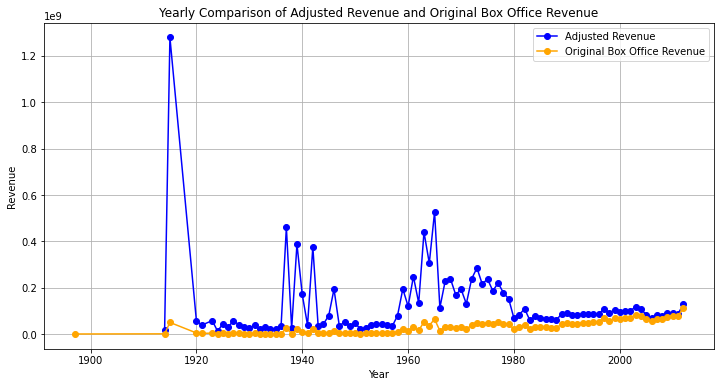

In [5]:
plot_by_year_comparison(cleaned_data)

<font color=Gray>We observe that the average box office revenue is exceptionally high in certain years, and we are interested in these outliers. First, we will sort the years by average box office revenue in descending order to identify the top six.</font>

In the line plot, we circle these outlier points to highlight them. It can be observed that most of these movies are from before 1970, making them old films!

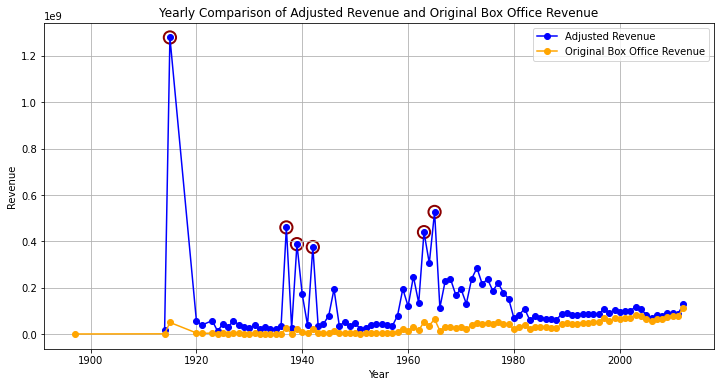

In [6]:
plot_by_year_comparison_outlier(cleaned_data)

We are particularly interested in the outlier for 1915 and have examined its details. This film, `The Birth of a Nation`, was directed by D.W. Griffith in 1915. Its high box office revenue can be attributed to both its controversial subject and pioneering filmmaking techniques. Additionally, the film had an unusually long theatrical run and was shown at higher ticket prices compared to typical films, which contributed significantly to its revenue. In 1915, the film industry was still in its early stages, and this movie faced almost no competition from other major productions (it is the only movie from 1915 in our dataset), allowing it to dominate the box office for an extended period.

In [7]:
filtered_data = cleaned_data[cleaned_data['Movie release year'] == 1915]
filtered_data

,Year,rate,averageRating,Wikipedia movie ID,Freebase movie ID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year,startYear,Primary Country,Adjusted_Revenue
243,1915.0,25.591503,6.1,3333,/m/0151l,The birth of a nation,50000000.0,190.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac...",1915,1915,United States of America,1.279575e+09


It is these unique films that have impacted the trend of average annual box office revenue, but how to handle these outliers still require further discussion in the future.

## <font color=DarkTurquoise>Observe Distribution</font>

<font color=Gray>We first examine the joint distribution of the two main variables in our study: `box office revenue` and `ratings`. We can see that the distribution of box office revenue is right-skewed, mainly concentrated in the lower range. Therefore, we need to apply a logarithmic transformation to the box office revenue, which is beneficial for subsequent data processing.</font>

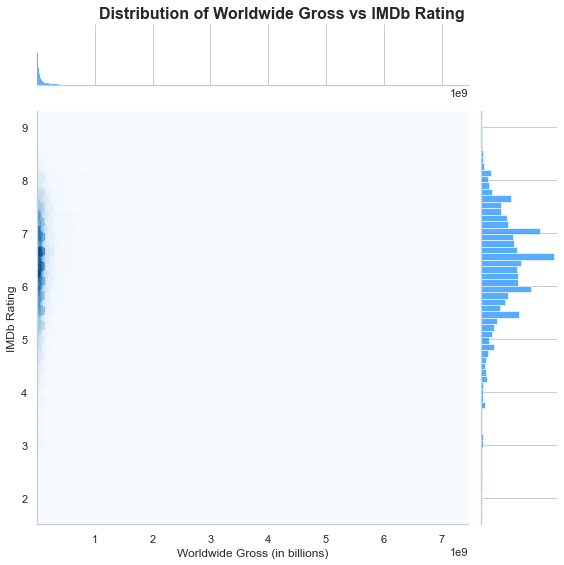

In [8]:
# Drop rows where 'Adjusted revenue' contains NaN values to avoid missing data in the plot
cleaned_data.drop(cleaned_data[cleaned_data['Adjusted_Revenue'].isnull()].index, inplace=True)
plot_distr_unadjusted(cleaned_data)

<font color=Gray>After applying a log transformation to the box office revenue, the new distribution appears more reasonable. We can also observe the range where ratings and box office revenue are concentrated.</font>

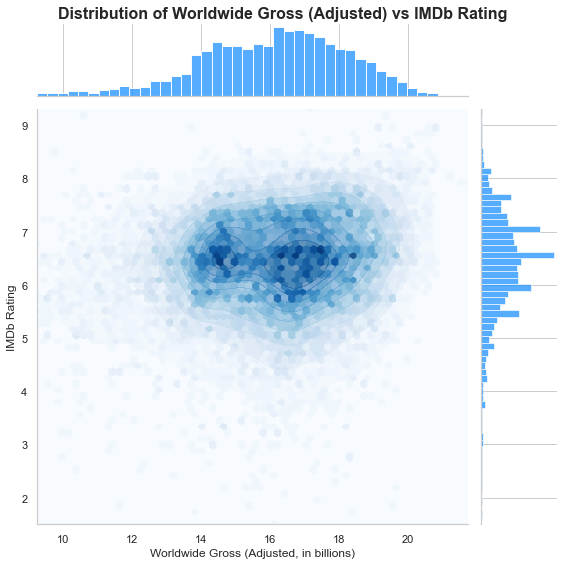

In [9]:
#Display the Adjusted World Gross vs. IMDb Rating plot with the same method when displaying Uadjusted World Gross vs. IMDb Rating plot
cleaned_data['Log_Revenue'] = np.log1p(cleaned_data['Movie box office revenue'])

# Drop rows where 'Log_Revenue' is null (e.g., missing or invalid box office data)
cleaned_data.drop(cleaned_data[cleaned_data['Log_Revenue'].isnull()].index, inplace=True)

plot_distr_adjusted(cleaned_data)

## <font color=DarkTurquoise>Linear Regression</font>

<font color=Gray>We perform a regression of `Log_Revenue` on `averageRating` to get a basic look at the linear relationship between the two. 

**Note:**
It should be noted that this regression likely suffers from omitted variable bias, as we need to consider more factors that could influence both box office revenue and ratings. However, since our dataset is still incomplete (currently being supplemented), this aspect will be addressed in Part 3.</font>

In [10]:
#Perform an Ordinary Least Squares (OLS) regression using the statsmodels library. 
model = smf.ols(formula='Log_Revenue ~ averageRating', data=cleaned_data).fit(cov_type='HC2')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Log_Revenue   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     164.4
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           3.13e-37
Time:                        23:07:52   Log-Likelihood:                -15992.
No. Observations:                7439   AIC:                         3.199e+04
Df Residuals:                    7437   BIC:                         3.200e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.9594      0.169     82.710

<font color=Gray>The regression coefficient for averageRating is **0.3349**, which suggests that for each one-unit increase in averageRating, the Log_Revenue is expected to increase by **0.3349**, holding other factors constant.

**t-Statistic (12.820) and p-Value (0.000):** The high t-statistic and p-value being effectively zero implies that the coefficient is significantly different from zero, reinforcing that averageRating has a statistically significant effect on Log_Revenue.</font>

## <font color=DarkTurquoise>Classification</font>

<font color=Gray>We categorize movies into three types: `those with matched box office and ratings`, `high box office with low ratings`, and `low box office with high ratings`. We are particularly interested in understanding the factors behind the latter two categories. 

The first issue to address is how to distinguish these three types. Our approach is to shift the regression line up and down by one standard deviation, dividing the plane into three regions. Points in the upper left (above the **green line**) are considered `Overperformed`  (high box office with low ratings), those in the lower right (lower than the **red line**) are `Underperformed` (low box office with high ratings), and points between the two lines fall into the **matched category**.</font>

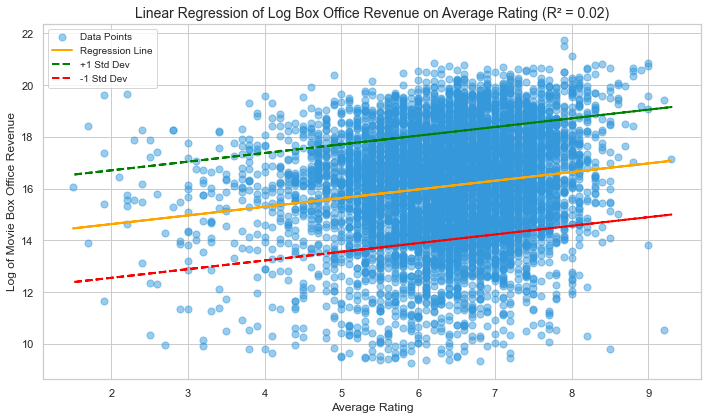

In [11]:
plot_correlation_general(cleaned_data, model)

Interactive version below (needs downloading; static plot should be enough from direct git viewing)

<font color=Gray>We aim to further examine the regression and classification for each country. The plots are shown below:

We can observe that:

(1) Most movies originate from the United States, France, South Korea, and the United Kingdom, while scatter plots for other countries are relatively sparse.

(2) In most countries, box office revenue tends to increase with higher ratings. The slope is particularly steep for the United States, the United Kingdom, Canada, Australia, and Hong Kong.</font>

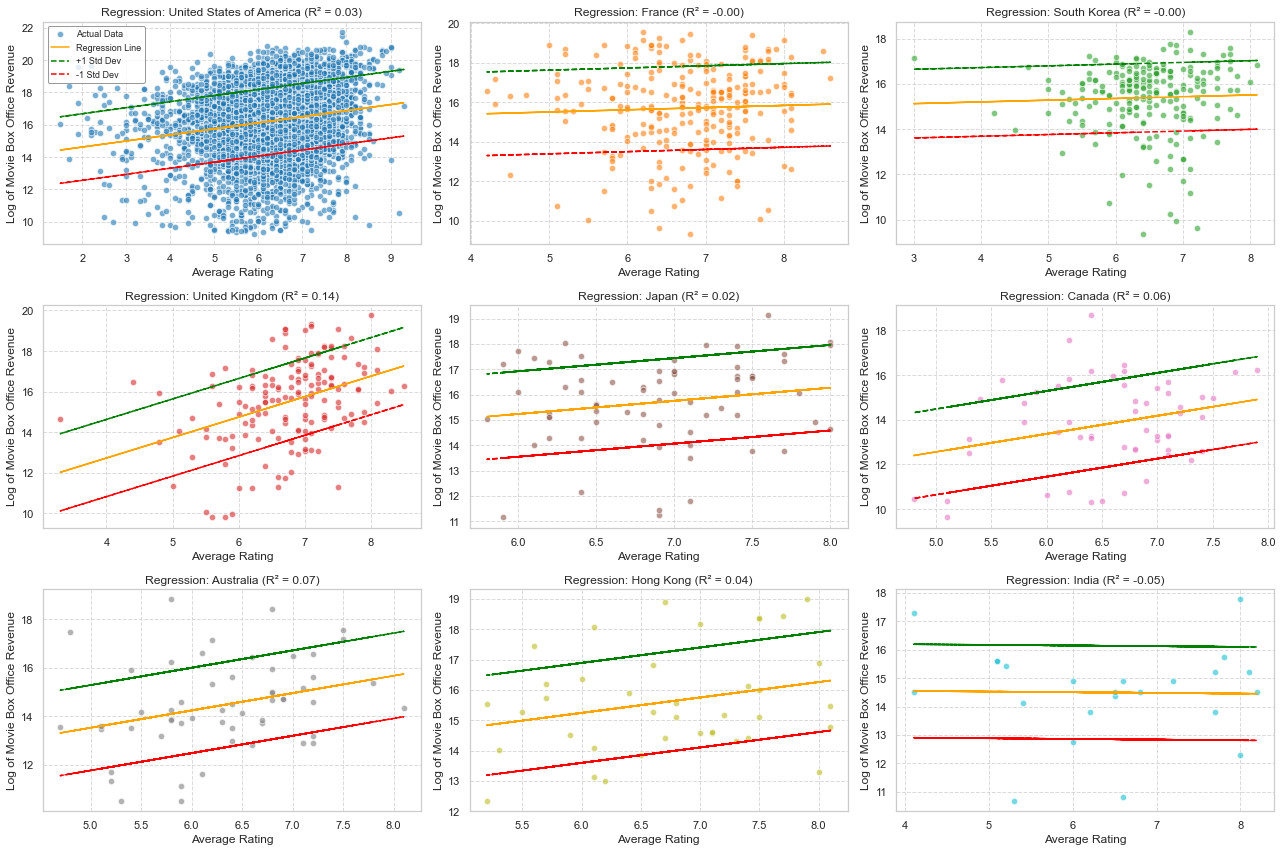

In [12]:
plot_correlation_per_country(cleaned_data)

<font color=Gray>We aim to further examine the regression and classification for ten time points (from 1915 to 2015). The plots are shown below:

We can observe that:

(1) From the overall trend, the number of movies has been increasing in recent years, which is reflected by the growing number of points in the scatter plots.

(2) The regression curves for nearly all years show an upward trend, indicating that box office revenue increases as ratings rise.
</font>

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1897: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = self.wresid**2/(1-h)


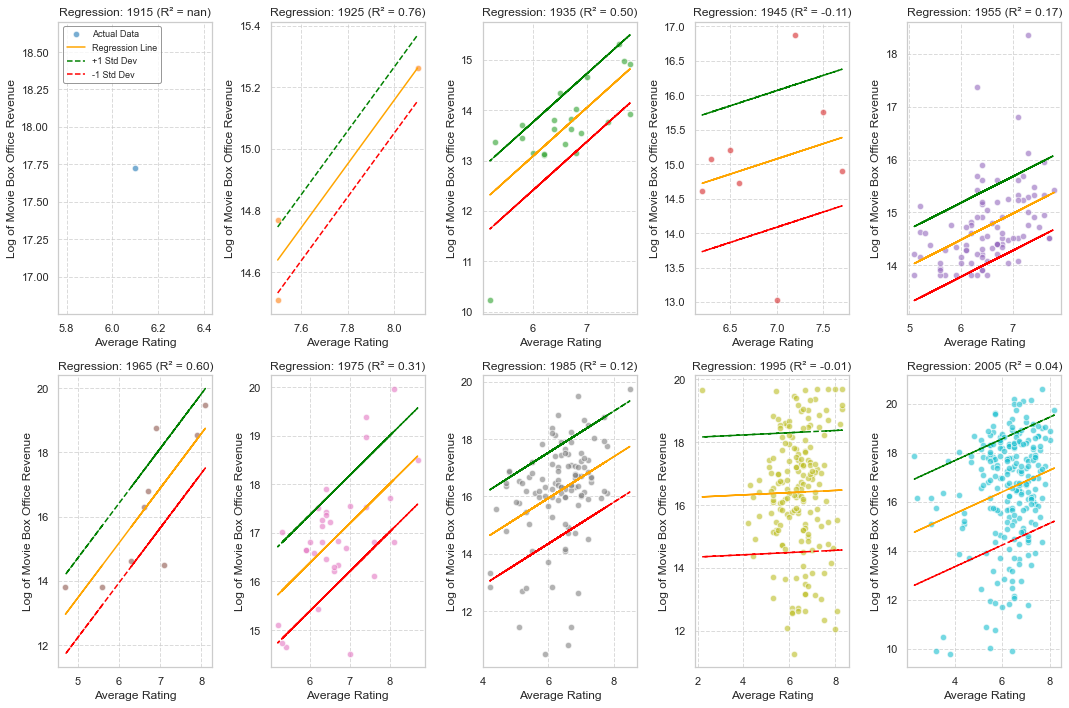

In [13]:
plot_correlation_per_timeframe(cleaned_data)

## <font color=DarkTurquoise>Overperformed VS Underperformed</font>

<font color=Gray>We can see that the number of movies defined as `Overperformed` is **1231**, while the number of movies defined as `Underperformed` is **1139**.</font>

In [14]:
predictions = model.predict()
std_dev = np.std(predictions - cleaned_data['Log_Revenue'])
# Calculate residuals by subtracting predictions from the actual Log_Revenue values
residuals = cleaned_data['Log_Revenue'] - predictions

# Identify outliers where the absolute value of residuals is greater than the standard deviation
outliers = cleaned_data[np.abs(residuals) > std_dev]['Log_Revenue']
print(outliers.count())  

# Separate data into two categories: higher and lower outliers
higher = cleaned_data[residuals > std_dev].copy()

# 'lower' contains rows where residuals are less than negative one standard deviation (negative outliers)
lower = cleaned_data[residuals < -std_dev].copy()

# Print the number of higher and lower outliers
print('length of higher:', len(higher), 'length of lower:', len(lower))


2370
length of higher: 1231 length of lower: 1139


<font color=Gray>Next, we examine the genre distribution of these two categories of movies separately. In our dataset, each movie’s genre is represented as a list, with the first genre indicating the primary category. We will start by analyzing the number of movies in each genre, sorting them from highest to lowest. Then, we will assess the percentage of each genre when it appears as the `first genre`, `second genre`, and `third genre`. We adopt this approach because we recognize all three genre slots might be important and that overlapping might exist between different genre slots, thus we aim to capture genre information as comprehensively as possible.</font>

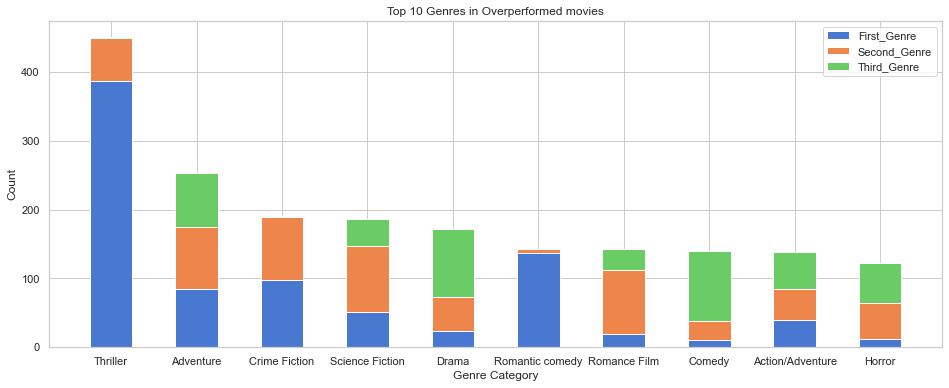

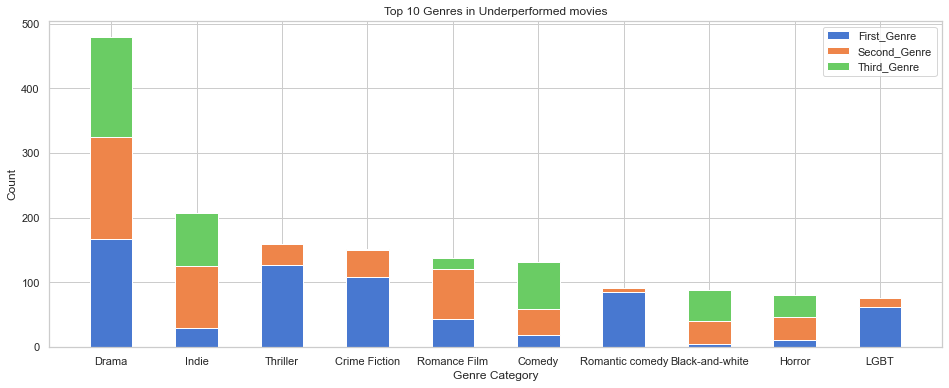

In [15]:
plot_genre_distribution(cleaned_data, model)

Interpretion: The above bar charts allow us to see the distribution of genres listed as "first", "second", and "third" genres slots, as well as distribution of genres in general since the ordering might not be semantically significant in the first place. A promising finding is that the *Thriller* genre appears to outclass the other genres in numbers among overperforming movies, while the same appears to hold true for the *Drama* genre among underperforming ones. This potentially indicates audience taste, and the factors (actors, etc.) that might've contributed to, or potentially even confounded, these results can be subject to further analysis later in the project.

<font color=Gray>Please also find below the interactive version of the movie genre distribution chart (download might be needed; non-interactive version should be sufficient for direct viewing from git).</font>

# Rejected Methologie(s)

One initially considered method to categorize/cluster movies into categories, two of which of our interest would've been "movies that perform well financially but received bad critical review" and "movies that underperformed financially but received critical acclaim", is to use straight-forward k-means clustering. This is abandoned since we discovered that the two-dimensional (box office vs rating) plotting of all movies are fairly continuous and does not lend itself well to discrete clustering. Hence the more generalized, standard deviation-based "overperformers" and "underperformers" categories we did end up using. Below is a visualization of different clusters.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

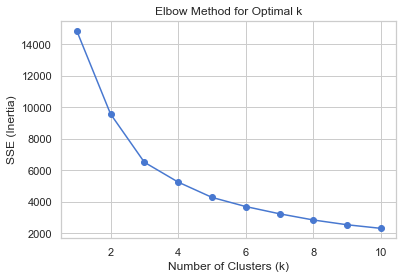

In [16]:
from tests.kmeanstest import *

kmeans_elbow_test(cleaned_data)

(k = 4 seems like a good elbow point, clustering using 4 k-means clusters below)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


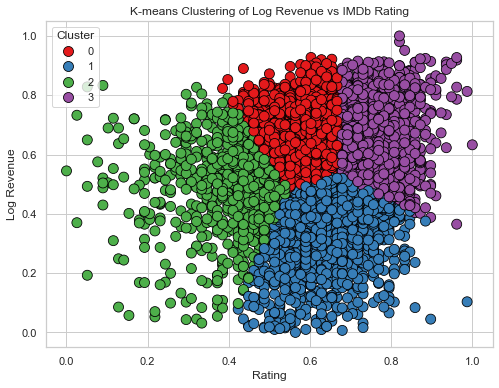

In [17]:
kmeans_test(cleaned_data, n_clusters=4)

Interpretation: Ideal positions for clusters that correspond to "movies that perform well financially but received bad critical review" and "movies that underperformed financially but received critical acclaim", respectively, would've ideally been confined to top-left and bottom-right quadrants respectively. Which even for k = 4 is not the case for the actual dataset.